In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from scipy.stats import pearsonr
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet

train_data = pd.read_csv('https://www.dropbox.com/scl/fi/52fq7m3blvjh98ylb8cj2/train.csv?rlkey=mfyb5gc9mpou11dzp70pwsejw&dl=1')
test_data = pd.read_csv('https://www.dropbox.com/scl/fi/faiqiqhmdvswmxdovtlkw/test.csv?rlkey=aqvj7rea2ekfkq437q6d9a8q1&dl=1')

#1. Data Cleaning, Preproessing and Wrangling

In [ ]:
#Filter columns with missing percentage more than 50
missing = train_data.isnull().sum() / len(train_data) * 100
missing_over_50 = missing[missing > 50]
print(missing_over_50)

Alley          93.767123
PoolQC         99.520548
Fence          80.753425
MiscFeature    96.301370
dtype: float64


In [ ]:
#Drop variables with high missing percentage
train_data = train_data.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence'])
test_data = test_data.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence'])

In [ ]:
#Create a new variable 'TotalArea'
train_data['SalePrice'] = np.log1p(train_data['SalePrice'])
train_data['TotalArea'] = train_data['TotalBsmtSF'] + train_data['1stFlrSF'] + train_data['2ndFlrSF']
test_data['TotalArea'] = test_data['TotalBsmtSF'] + test_data['1stFlrSF'] + test_data['2ndFlrSF']

#Identify numeric and categorical features
num_features = train_data.select_dtypes(include=[np.number]).columns.tolist()
cat_features = train_data.select_dtypes(exclude=[np.number]).columns.tolist()

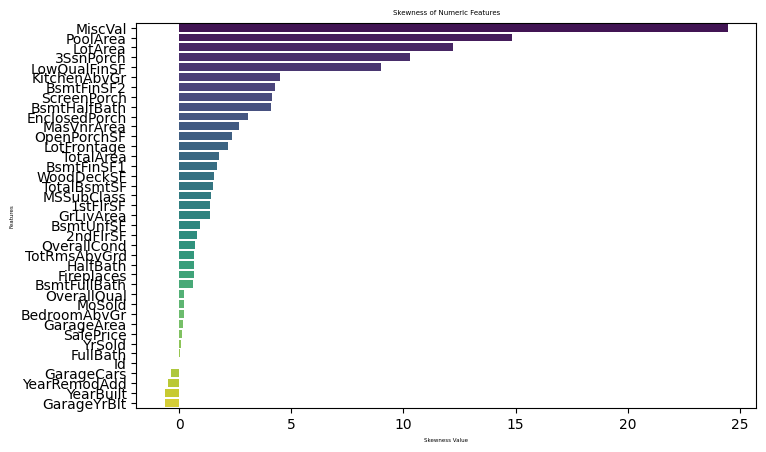

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Select numeric features
numeric_features = train_data.dtypes[train_data.dtypes != 'object'].index
#Calculate skewness
skewed_features = train_data[numeric_features].apply(lambda x: x.skew()).sort_values(ascending=False)
#Plot skewness
plt.figure(figsize=(8,5))
sns.barplot(y=skewed_features.index, x=skewed_features.values, palette="viridis")
plt.xlabel('Skewness Value', fontsize=4)
plt.ylabel('Features', fontsize=4)
plt.title('Skewness of Numeric Features', fontsize=5)
plt.show()

In [ ]:
#Filter those skeweness are greater than 1
numeric_features = train_data.dtypes[train_data.dtypes != 'object'].index
skewed_features = train_data[numeric_features].apply(lambda x: x.skew()).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 1]

#log high skew variables
for feature in high_skew.index:
    train_data[feature] = np.log1p(train_data[feature])
    test_data[feature] = np.log1p(test_data[feature])

#Fill Nan
for feature in num_features:
    if feature != 'SalePrice':
        median_value = train_data[feature].median()
        train_data[feature].fillna(median_value, inplace=True)
        test_data[feature].fillna(median_value, inplace=True)
for feature in cat_features:
    mode_value = train_data[feature].mode()[0]
    train_data[feature].fillna(mode_value, inplace=True)
    test_data[feature].fillna(mode_value, inplace=True)

#Set dummy variables
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)
final_features = list(set(train_data.columns).intersection(test_data.columns))

#Redefine training and testing data
X = train_data[final_features]
test_X = test_data[final_features]
y = train_data['SalePrice']
median_total_area = train_data['TotalArea'].median()
test_X['TotalArea'].fillna(median_total_area, inplace=True)

<ipython-input-69-c7b103542d34>:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# 2. Linear Regression

### Applying OLS

In [ ]:
#Model training
LR_model = LinearRegression()
LR_model.fit(X, y)

LinearRegression()

In [ ]:
coefficients_LR = LR_model.coef_
feature_names_LR = X.columns
print("Linear Regression Coefficients:")
for feature, coef in zip(feature_names_LR, coefficients_LR ):
    print(f"{feature}: {coef:.4f}")

Linear Regression Coefficients:
GarageQual_TA: -0.3505
BsmtQual_Gd: -0.0157
LotShape_IR1: 0.0164
GarageArea: 0.0000
Neighborhood_Crawfor: 0.1007
BldgType_Twnhs: -0.0165
Condition2_Feedr: 0.0800
HouseStyle_1Story: 0.0959
Exterior1st_AsbShng: 0.0726
BsmtFinType1_BLQ: -0.0090
GarageCond_Po: 0.1144
Exterior1st_Wd Sdng: -0.0096
GarageQual_Gd: -0.3132
MoSold: -0.0010
Exterior1st_VinylSd: 0.0186
SaleCondition_Family: -0.0217
FireplaceQu_TA: -0.0011
Exterior1st_MetalSd: 0.0728
BsmtExposure_No: -0.0171
BsmtCond_TA: 0.0153
BsmtExposure_Av: -0.0041
Exterior2nd_HdBoard: 0.0825
MasVnrType_BrkCmn: -0.0300
CentralAir_Y: 0.0273
HeatingQC_Gd: 0.0041
LandContour_Bnk: -0.0280
MSZoning_FV: 0.1139
HouseStyle_2.5Unf: 0.0833
Fireplaces: 0.0155
MSZoning_C (all): -0.3366
Neighborhood_CollgCr: -0.0117
KitchenAbvGr: -0.1238
OverallCond: 0.0362
ExterQual_Gd: -0.0156
Exterior2nd_Plywood: 0.0809
SaleCondition_Abnorml: -0.0279
Neighborhood_NPkVill: 0.0096
SaleType_ConLI: -0.0649
SaleType_Oth: 0.0277
OpenPorchSF: 0.0

### Graph about Coefficients in Linear Regression

In [ ]:
coeff_df = pd.DataFrame({'Feature': feature_names_LR, 'Coefficient': coefficients_LR})


# Create an interactive scatter plot using Plotly
fig = px.scatter(coeff_df, x='Feature', y='Coefficient',
                 title='Linear Regression Coefficients', labels={'Coefficient': 'Coefficient Value'},
                 color_discrete_sequence=['red'])
# Customize layout
fig.update_layout(xaxis={'tickangle': -45, 'title': 'Feature'},
                  yaxis={'title': 'Coefficient'},
                  showlegend=False)
fig.update_yaxes(range=[-0.1, 0.1])

# Show the interactive plot
fig.show()

#3. Data scaling

In [ ]:
X_column_name = X.columns.tolist()
test_X_column_name = test_X.columns.tolist()

In [ ]:
len(X_column_name)

261

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_X_scaled = scaler.fit_transform(test_X)
Lasso_X = pd.DataFrame(X_scaled,columns=X_column_name)
Elastic_X = pd.DataFrame(X_scaled,columns=X_column_name)
test_X = pd.DataFrame(test_X_scaled,columns=test_X_column_name)

# 4. Linear Regression with Lasso

### Applying Lasso in Linear Regression

In [ ]:
lasso_cv_model = LassoCV(alphas=np.logspace(-5, 0, num=200), cv=5)
# Fit the LassoCV model to the scaled training data
lasso_cv_model.fit(Lasso_X, y)

LassoCV(alphas=array([1.00000000e-05, 1.05956018e-05, 1.12266777e-05, 1.18953407e-05,
       1.26038293e-05, 1.33545156e-05, 1.41499130e-05, 1.49926843e-05,
       1.58856513e-05, 1.68318035e-05, 1.78343088e-05, 1.88965234e-05,
       2.00220037e-05, 2.12145178e-05, 2.24780583e-05, 2.38168555e-05,
       2.52353917e-05, 2.67384162e-05, 2.83309610e-05, 3.00183581e-05,
       3.18062569e-05, 3.37006433e-0...
       2.64308149e-01, 2.80050389e-01, 2.96730241e-01, 3.14403547e-01,
       3.33129479e-01, 3.52970730e-01, 3.73993730e-01, 3.96268864e-01,
       4.19870708e-01, 4.44878283e-01, 4.71375313e-01, 4.99450512e-01,
       5.29197874e-01, 5.60716994e-01, 5.94113398e-01, 6.29498899e-01,
       6.66991966e-01, 7.06718127e-01, 7.48810386e-01, 7.93409667e-01,
       8.40665289e-01, 8.90735464e-01, 9.43787828e-01, 1.00000000e+00]),
        cv=5)

In [ ]:
# The optimal alpha selected by cross-validation
optimal_alpha = lasso_cv_model.alpha_
print("Optimal Alpha:", optimal_alpha)

Optimal Alpha: 0.004102658105827195


In [ ]:
lasso_model = Lasso(alpha=optimal_alpha)
lasso_model.fit(Lasso_X, y)
sum(lasso_model.coef_!=0)

92

In [ ]:
cv_results = pd.DataFrame({'alpha': lasso_cv_model.alphas_,
                           'mse': np.mean(lasso_cv_model.mse_path_, axis=1),
                           'std_error': np.std(lasso_cv_model.mse_path_, axis=1)})

fig = px.line(cv_results, x='alpha', y='mse')
fig.update_layout(title='Lasso Cross-Validation Results',
                  xaxis_title='Alpha',
                  xaxis_type='log',
                  yaxis_title='Mean Squared Error')
fig.update_traces(error_y=dict(type='data', array=cv_results['std_error']))



fig.show()

In [ ]:
lasso_coefficients = lasso_model.coef_
feature_names = X.columns

# Initialize the OLS regression model
LR_model = LinearRegression()
LR_model.fit(X, y)

# Get the coefficients for OLS
ols_coefficients = LR_model.coef_

# Create DataFrames for Lasso and OLS coefficients
lasso_coeff_df =  pd.DataFrame({'Feature': feature_names, 'Lasso Coefficient': lasso_coefficients})
ols_coeff_df = pd.DataFrame({'Feature': feature_names, 'OLS Coefficient': ols_coefficients})

# Combine the DataFrames
combined_coeff_df = pd.merge(lasso_coeff_df, ols_coeff_df, on='Feature')




###Graph about Lasso and OLS Regression Coefficients

In [ ]:
# Create an interactive scatter plot using Plotly
fig = px.scatter(combined_coeff_df, x='Feature', y=['Lasso Coefficient', 'OLS Coefficient'],
                 title='Lasso vs OLS Regression Coefficients', labels={'value': 'Coefficient'})

# Customize layout
fig.update_layout(xaxis={'tickangle': -45, 'title': 'Feature'},
                  yaxis={'title': 'Coefficient'})
fig.update_yaxes(range=[-0.1, 0.1])  # Adjust the range as needed

# Show the interactive plot
fig.show()

# 5. Linear Regression with Elastic Net

###Applying Elastic Net in Linear Regression

In [ ]:
# elastic net and cross-validation selection
alphas = np.logspace(-5, 0, 200)  # Range of alpha values to test
l1_ratios = np.arange(0.1, 1.0, 0.1)
elastic_net = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5)
elastic_net.fit(Elastic_X, y)
best_alpha = elastic_net.alpha_
best_l1_ratio = elastic_net.l1_ratio_

In [ ]:
print(best_alpha, best_l1_ratio)

0.04150404757850477 0.1


In [ ]:
alpha = best_alpha
l1_ratio = best_l1_ratio
elastic_net_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
elastic_net_model.fit(Elastic_X, y)

ElasticNet(alpha=0.04150404757850477, l1_ratio=0.1, random_state=42)

In [ ]:
import plotly.graph_objects as go

mse_means = elastic_net.mse_path_.mean(axis=2)
mse_stds = elastic_net.mse_path_.std(axis=2)

fig = go.Figure()

for i, l1 in enumerate(l1_ratios):
    fig.add_trace(go.Scatter(
        x=alphas,
        y=mse_means[i],
        mode='lines',
        name=f'l1_ratio={l1:.1f}',
        line=dict(shape='spline'),
        error_y=dict(type='data', array=mse_stds[i], visible=True)
    ))

fig.update_layout(
    title='Validation Curves for Different l1_ratios',
    xaxis=dict(type='log', title='Alpha'),
    yaxis=dict(title='Mean Squared Error')
)


fig.show()


In [ ]:
lasso_coefficients = lasso_model.coef_
feature_names = X.columns

elastic_net_model_coeff_df = pd.DataFrame({'Feature': feature_names, 'Elastic Net Coefficient': elastic_net_model_coefficients})


# Combine the DataFrames
combined_coeff_df = pd.merge(lasso_coeff_df, ols_coeff_df, on='Feature')
combined_coeff_df = pd.merge(combined_coeff_df, elastic_net_model_coeff_df, on
# Initialize the OLS regression model
LR_model = LinearRegression()
LR_model.fit(X, y)

# Initialize the OLS regression model
elastic_net_model_coefficients = elastic_net_model.coef_
elastic_net_model.fit(Elastic_X, y)

# Get the coefficients for OLS
ols_coefficients = LR_model.coef_

# Create DataFrames for Lasso and OLS coefficients
lasso_coeff_df =  pd.DataFrame({'Feature': feature_names, 'Lasso Coefficient': lasso_coefficients})
ols_coeff_df = pd.DataFrame({'Feature': feature_names, 'OLS Coefficient': ols_coefficients})='Feature')



###Graph about Lasso and OLS Regression Coefficients

In [ ]:
# Create an interactive scatter plot using Plotly
fig = px.scatter(combined_coeff_df, x='Feature', y=['Lasso Coefficient', 'OLS Coefficient','Elastic Net Coefficient'],
                 title='Lasso vs OLS Regression VS Elastic Net Coefficients', labels={'value': 'Coefficient'})

# Customize layout
fig.update_layout(xaxis={'tickangle': -45, 'title': 'Feature'},
                  yaxis={'title': 'Coefficient'})
fig.update_yaxes(range=[-0.1, 0.1])  # Adjust the range as needed

# Show the interactive plot
fig.show()

# 6. Model Selection

In [ ]:
y_pred_LR = LR_model.predict(X)
mse_LR = mean_squared_error(y, y_pred_LR)
formatted_mse_LR = "{:.10f}".format(mse_LR)
print("Formatted MSE in OLS:", formatted_mse_LR)

y_pred_lasso = lasso_model.predict(Lasso_X)
mse_lasso = mean_squared_error(y, y_pred_lasso)
formatted_mse_lasso = "{:.10f}".format(mse_lasso)
print("Formatted MSE in Lasso:", formatted_mse_lasso)

y_pred_elastic = elastic_net_model.predict(Elastic_X)
mse_elastic = mean_squared_error(y, y_pred_elastic)
formatted_mse_elastic = "{:.10f}".format(mse_elastic)
print("Formatted MSE Elastic Net:", formatted_mse_elastic)

Formatted MSE in OLS: 0.0095889948
Formatted MSE in Lasso: 0.0117431516
Formatted MSE Elastic Net: 0.0118107806


In [ ]:
from IPython.display import display, HTML

data = {
    'OLS': round(mse_LR, 6),
    'Lasso': round(mse_lasso, 6),
    'Elastic Net': round(mse_elastic, 6)
}
sorted_data = sorted(data.items(), key=lambda x: x[1])
sorted_data_dict = {model: mse for model, mse in sorted_data}
df = pd.DataFrame([sorted_data_dict], index=['MSE'])

from google.colab import drive

drive.mount('/content/drive')
df.to_csv('/content/drive/MyDrive/mse_results.csv',index = False)
display(HTML(df.to_html(index=False)))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


OLS,Lasso,Elastic Net
0.009589,0.011743,0.011811


# 7. Prediction Using Elastic Net

In [ ]:
#Model training
final_predictions = lasso_model.predict(test_X)
final_predictions = np.expm1(final_predictions)
final_predictions

array([119420.53693072, 155762.85761014, 184194.38276449, ...,
       165387.68425227, 123643.7374687 , 232304.55418698])

In [ ]:
#Generate the submission file
from google.colab import drive
drive.mount('/content/drive')
sample_submission_df = pd.read_csv('https://www.dropbox.com/scl/fi/fxiwfe47v7odz6qdukl0h/sample_submission.csv?rlkey=v8eknwjn58j9t0v9wu856yx6c&dl=1')
sample_submission_df['SalePrice'] = final_predictions
sample_submission_df.to_csv('/content/drive/MyDrive/Assignment 3.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
